## Development notebook  FCN model 

Evaluate returned heatmap values from FCN, by passing data through MRCNN and then through FCN

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, math, io, time, gc, argparse, platform, pprint
import numpy as np
import tensorflow as tf
import keras
import keras.backend as KB
sys.path.append('../')
import mrcnn.visualize    as visualize
import mrcnn.utils        as utils

from datetime           import datetime   
from mrcnn.utils        import command_line_parser, Paths
from mrcnn.config       import Config
from mrcnn.dataset      import Dataset 
from mrcnn.utils        import log   ##, stack_tensors, stack_tensors_3d, write_stdout
from mrcnn.coco         import prep_coco_dataset # CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results
from mrcnn.prep_notebook import mrcnn_newshape_train,build_fcn_training_pipeline, build_fcn_training_pipeline_newshapes
from mrcnn.newshapes    import prep_newshape_dataset
from mrcnn.datagen  import data_gen_simulate

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
parser = command_line_parser()
input_parms = " --epochs          2 "
input_parms +=" --steps_in_epoch 10 " 
input_parms +=" --val_steps       2 " 
input_parms +=" --last_epoch      0 "
input_parms +=" --batch_size      1 "
input_parms +=" --lr        0.00001 "
# input_parms +=" --mrcnn_logs_dir train_mrcnn_newshapes "
# input_parms +=" --fcn_logs_dir   train_fcn32_newshapes "
# input_parms +="--fcn_logs_dir   train_fcn8_newshapes "
# input_parms +=" --scale_factor     1 " 
input_parms +="--mrcnn_logs_dir train_mrcnn_coco_subset "
input_parms +="--fcn_logs_dir   train_fcn8_bce "
input_parms +=" --scale_factor     4 " 
input_parms +=" --coco_classes   78 79 80 81 82 44 46 47 48 49 50 51 34 35 36 37 38 39 40 41 42 43 10 11 13 14 15 "

input_parms +="--mrcnn_model    last "
input_parms +="--fcn_model      init "
input_parms +="--opt            adagrad "
input_parms +="--fcn_arch       fcn8 " 
input_parms +="--fcn_layers     all " 
input_parms +=" --sysout        screen "
input_parms +=" --new_log_folder   "        

parser = utils.command_line_parser()
args = parser.parse_args(input_parms.split())
utils.display_input_parms(args)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Arguments passed :
--------------------
batch_size                     1
coco_classes                   [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
epochs                         2
fcn_arch                       FCN8
fcn_layers                     ['all']
fcn_logs_dir                   train_fcn8_bce
fcn_losses                     fcn_BCE_loss
fcn_model                      init
last_epoch                     0
lr                             0.00001
mrcnn_exclude_layers           None
mrcnn_layers                   mrcnn fpn rpn 
mrcnn_logs_dir                 train_mrcnn_coco_subset
mrcnn_model                    last
new_log_folder                 True
opt                            ADAGRAD
scale_factor                   4
steps_in_epoch                 10
sysout                         SCREEN
val_steps                      2




In [4]:
mrcnn_model, fcn_model = build_fcn_training_pipeline(args = args, verbose = 1)


--> Execution started at: 12-21-2018 @ 15:48:36
    Tensorflow Version: 1.8.0   Keras Version : 2.2.0 

Arguments passed :
--------------------
batch_size                     1
coco_classes                   [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
epochs                         2
fcn_arch                       FCN8
fcn_layers                     ['all']
fcn_logs_dir                   train_fcn8_bce
fcn_losses                     fcn_BCE_loss
fcn_model                      init
last_epoch                     0
lr                             0.00001
mrcnn_exclude_layers           None
mrcnn_layers                   mrcnn fpn rpn 
mrcnn_logs_dir                 train_mrcnn_coco_subset
mrcnn_model                    last
new_log_folder                 True
opt                            ADAGRAD
scale_factor                   4
steps_in_epoch                 10
sysout                         SCREEN
val_steps              

    X/Y shapes : (256, 256) (256, 256)
    Ones:     (?, 1, 1)
    ones_exp * X (?, 1, 1) * (256, 256) =  (?, 256, 256)
    ones_exp * Y (?, 1, 1) * (256, 256) =  (?, 256, 256)
    pos_grid before transpse       :  shape: (?, 256, 256, 2)      KB.shape:(None, 256, 256, 2)   Keras Tensor: False
    pos_grid after transpose       :  shape: (256, 256, ?, 2)      KB.shape:(256, 256, None, 2)   Keras Tensor: False
    Input to MVN.PROB: pos_grid (meshgrid):  shape: (256, 256, ?, 2)      KB.shape:(256, 256, None, 2)   Keras Tensor: False
    Prob_grid shape from mvn.probe :  shape: (256, 256, ?)         KB.shape:(256, 256, None)      Keras Tensor: False
    Prob_grid shape after tanspose :  shape: (?, 256, 256)         KB.shape:(None, 256, 256)      Keras Tensor: False
    Output probabilities shape     :  shape: (?, 256, 256)         KB.shape:(None, 256, 256)      Keras Tensor: False
    old_style_scores        :      :  shape: (1, 81, 200, 3)       KB.shape:(1, 81, 200, 3)       Keras Tens

    complete                       
    pr_hm                          :  shape: (1, 256, 256, 81)     KB.shape:(None, 1024, 1024, 81)  Keras Tensor: True
    gt_hm                          :  shape: (1, 256, 256, 81)     KB.shape:(None, 1024, 1024, 81)  Keras Tensor: True

>>> Build MaskRCNN build complete. mode:  trainfcn
>>> MaskRCNN initialiation complete. Mode:  trainfcn
>>> Initialize ModelBase model 
   Mode      :  training
   Model dir :  F:\models\train_fcn8_bce
>>> set_log_dir(): model_path:  None
    set_log_dir(): model_path has NOT been provided : None 
                   NewFolder: False  config.NEW_LOG_FOLDER: True 
    set_log_dir(): weight file template (self.checkpoint_path): F:\models\train_fcn8_bce\fcn20181221T1548\fcn_{epoch:04d}.h5 
    set_log_dir(): weight file dir      (self.log_dir)        : F:\models\train_fcn8_bce\fcn20181221T1548 
    set_log_dir(): Last completed epoch (self.epoch)          : 0 
>>> ModelBase initialiation complete
>>> Initialize FCN mode

    pt2_dense shape                :  shape: (?, 23)               KB.shape:(None, 23)            Keras Tensor: False
    hm_indices                     :  shape: (?, 2)                KB.shape:(None, 2)             Keras Tensor: False
    pt2_heatmaps                   :  shape: (?, 81, 256, 256)     KB.shape:(None, 81, 256, 256)  Keras Tensor: False
    pt2_heatmaps                   :  shape: (?, 256, 256)         KB.shape:(None, 256, 256)      Keras Tensor: False
    old_style_scores               :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    alt_scores_1                   :  shape: (?, 3)                KB.shape:(None, 3)             Keras Tensor: False
    alt_scores_1_scattered         :  shape: (1, 81, 200, 3)       KB.shape:(1, 81, 200, 3)       Keras Tensor: False
    alt_scores_1_norm(by_class)    :  shape: (1, 81, 200, 3)       KB.shape:(1, 81, 200, 3)       Keras Tensor: False
    alt_scores_1_norm(by_image)    :  shape: (?, 3)     

    loss final        : (1, 1) (1, 1) KerasTensor:  False
 self.keras_model.losses :  0

>>> FCN build complete. mode:  training
>>> FCN initialization complete. mode:  training

 MRCNN IO Layers 
 --------------- 
 Inputs:
 -------
 index:  0    input name : input_image:0                              Type: float32           Shape: (?, 1024, 1024, 3)
 index:  1    input name : input_image_meta:0                         Type: float32           Shape: (?, ?)
 index:  2    input name : input_rpn_match:0                          Type: int32             Shape: (?, ?, 1)
 index:  3    input name : input_rpn_bbox:0                           Type: float32           Shape: (?, ?, 4)
 index:  4    input name : input_gt_class_ids:0                       Type: int32             Shape: (?, ?)
 index:  5    input name : input_gt_boxes:0                           Type: float32           Shape: (?, ?, 4)
 Outputs:
 --------
 layer:  0    output name: cntxt_layer/pred_heatmap:0                 Type: fl

In [ ]:
# exclude=["mrcnn_class_logits"] # ,"mrcnn_bbox_fc"]   #, "mrcnn_bbox", "mrcnn_mask"])
# mrcnn_model.load_model_weights(init_with = 'last', exclude = None)  

In [ ]:
##------------------------------------------------------------------------------------
## Load FCN Model weights  
##------------------------------------------------------------------------------------
# WEIGHTS_PATH = '/home/kbardool/models/train_fcn8_coco/fcn20181031T0000/fcn_0106.h5'
# fcn_model.load_model_weights(init_with = WEIGHTS_PATH) # 'fcn_config.VGG16_MODEL_PATH')

In [ ]:
# mrcnn_model.config.EPOCHS_TO_RUN = 1
fcn_model.config.display()  
# mrcnn_model.layer_info()

##  Build FCN Model 

In [ ]:
##----------------------------------------------------------------------------------------------
## if debug is true set stdout destination to stringIO
##----------------------------------------------------------------------------------------------            
# debug = False
if args.sysout == 'FILE':
    sys.stdout = io.StringIO()

# print("    Dataset            : ", args.dataset)
# print("    Logs               : ", args.logs)
# print("    Limit              : ", args.limit)
print("    MRCNN Model        : ", args.mrcnn_model)
print("    FCN Model          : ", args.fcn_model)
print("    MRCNN Log Dir      : ", args.mrcnn_logs_dir)
print("    FCN Log Dir        : ", args.fcn_logs_dir)
print("    FCN Arch           : ", args.fcn_arch)
print("    FCN Log Dir        : ", args.fcn_layers)
print("    Last Epoch         : ", args.last_epoch)
print("    Epochs to run      : ", args.epochs)
print("    Steps in each epoch: ", args.steps_in_epoch)
print("    Validation steps   : ", args.val_steps)
print("    Batch Size         : ", args.batch_size)
print("    Optimizer          : ", args.opt)
print("    sysout             : ", args.sysout)
# print("    OS Platform        : ", syst)

##------------------------------------------------------------------------------------
## setup project directories
##   ROOT_DIR         : Root directory of the project 
##   MODEL_DIR        : Directory to save logs and trained model
##   COCO_MODEL_PATH  : Path to COCO trained weights
##---------------------------------------------------------------------------------
paths = Paths(fcn_training_folder = args.fcn_logs_dir, mrcnn_training_folder = args.mrcnn_logs_dir)
paths.display()

##------------------------------------------------------------------------------------
## Build configuration object 
##------------------------------------------------------------------------------------                          
mrcnn_config                    = CocoConfig()
# import mrcnn.new_shapes as new_shapes
# mrcnn_config = new_shapes.NewShapesConfig()

mrcnn_config.NAME               = 'mrcnn'              
mrcnn_config.TRAINING_PATH      = paths.MRCNN_TRAINING_PATH
mrcnn_config.COCO_DATASET_PATH  = paths.COCO_DATASET_PATH 
mrcnn_config.COCO_MODEL_PATH    = paths.COCO_MODEL_PATH   
mrcnn_config.RESNET_MODEL_PATH  = paths.RESNET_MODEL_PATH 
mrcnn_config.VGG16_MODEL_PATH   = paths.VGG16_MODEL_PATH  
mrcnn_config.COCO_CLASSES       = None 
mrcnn_config.DETECTION_PER_CLASS = 200
mrcnn_config.HEATMAP_SCALE_FACTOR = 4
mrcnn_config.BATCH_SIZE         = int(args.batch_size)                  # Batch size is 2 (# GPUs * images/GPU).
mrcnn_config.IMAGES_PER_GPU     = int(args.batch_size)                  # Must match BATCH_SIZE

mrcnn_config.STEPS_PER_EPOCH    = int(args.steps_in_epoch)
mrcnn_config.LEARNING_RATE      = float(args.lr)
mrcnn_config.EPOCHS_TO_RUN      = int(args.epochs)
mrcnn_config.FCN_INPUT_SHAPE    = mrcnn_config.IMAGE_SHAPE[0:2]
mrcnn_config.LAST_EPOCH_RAN     = int(args.last_epoch)

mrcnn_config.WEIGHT_DECAY       = 2.0e-4
mrcnn_config.VALIDATION_STEPS   = int(args.val_steps)
mrcnn_config.REDUCE_LR_FACTOR   = 0.5
mrcnn_config.REDUCE_LR_COOLDOWN = 30
mrcnn_config.REDUCE_LR_PATIENCE = 40
mrcnn_config.EARLY_STOP_PATIENCE= 80
mrcnn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
mrcnn_config.MIN_LR             = 1.0e-10
mrcnn_config.OPTIMIZER          = args.opt.upper()
mrcnn_config.NEW_LOG_FOLDER       = True
mrcnn_config.SYSOUT               = args.sysout
mrcnn_config.display() 


###  Build Model

from mrcnn.prep_notebook import mrcnn_coco_train
mrcnn_model, mrcnn_config = mrcnn_coco_train(mode = 'trainfcn', mrcnn_config = mrcnn_config)

In [ ]:
##------------------------------------------------------------------------------------
## Build configuration for FCN model
##------------------------------------------------------------------------------------
# fcn_config = CocoConfig()
# fcn_config.NAME                 = 'fcn'              
# fcn_config.TRAINING_PATH        = paths.FCN_TRAINING_PATH
# fcn_config.VGG16_MODEL_PATH     = paths.FCN_VGG16_MODEL_PATH
# fcn_config.FCN_INPUT_SHAPE      = mrcnn_config.IMAGE_SHAPE[0:2] // mrcnn_config.HEATMAP_SCALE_FACTOR 

# fcn_config.BATCH_SIZE           = int(args.batch_size)                  # Batch size is 2 (# GPUs * images/GPU).
# fcn_config.IMAGES_PER_GPU       = int(args.batch_size)                  # Must match BATCH_SIZE
# fcn_config.EPOCHS_TO_RUN        = int(args.epochs)
# fcn_config.STEPS_PER_EPOCH      = int(args.steps_in_epoch)
# fcn_config.LEARNING_RATE        = float(args.lr)
# fcn_config.LAST_EPOCH_RAN       = int(args.last_epoch)
# fcn_config.VALIDATION_STEPS     = int(args.val_steps)

# fcn_config.WEIGHT_DECAY         = 2.0e-4     ## FCN Weight decays are 5.0e-4 or 2.0e-4
# fcn_config.BATCH_MOMENTUM       = 0.9

# fcn_config.REDUCE_LR_FACTOR     = 0.5
# fcn_config.REDUCE_LR_COOLDOWN   = 15
# fcn_config.REDUCE_LR_PATIENCE   = 50
# fcn_config.REDUCE_LR_MIN_DELTA  = 1e-6

# fcn_config.EARLY_STOP_PATIENCE  = 75
# fcn_config.EARLY_STOP_MIN_DELTA = 1.0e-7

# fcn_config.MIN_LR               = 1.0e-10
# fcn_config.CHECKPOINT_PERIOD    = 1

# fcn_config.NEW_LOG_FOLDER       = args.new_log_folder
# fcn_config.OPTIMIZER            = args.opt.upper()
# fcn_config.SYSOUT               = args.sysout
# fcn_config.display()

#### Build Model

In [ ]:
##------------------------------------------------------------------------------------
## Build FCN Model in Training Mode
##------------------------------------------------------------------------------------
# try :
#     del fcn_model
#     gc.collect()
# except: 
#     pass    
# fcn_model = fcn_modellib.FCN(mode="training", arch = 'FCN8', config=fcn_config)


In [ ]:
fcn_model.keras_model.summary()
fcn_model.layer_info()
# fcn_model.config.display()

In [ ]:
# del fcn_m
ff = fcn_model.keras_model
# pp.pprint(dir(ff))
# for i in ff.layers:
#     print(i.name)
ly = ff.layers[35]
dir(ly)
print(ly.input, ly.input_shape)
print(ly.output, ly.output_shape)
# test = [None] *len(fcn_m.targets)

print('ff.outputNames', ff.output_names)
print('ff.outputShapes', ff.output_shape)

print('ff.targets :', len(ff.targets))
for tensor in ff.targets:
      print('  ', tensor)
print('ff.inputs  :', len(ff.inputs))
for tensor in ff.inputs:
      print('   ', tensor)
print('fd.sample_weights :', ff.sample_weights)
print('ff.input          :', len(ff.input))
print('_feed_input_nmes: ', ff._feed_input_names)
print('_feed_output_nmes: ', ff._feed_output_names)

## Load datasets

In [5]:
##------------------------------------------------------------------------------------
## Build & Load Training and Validation datasets
##------------------------------------------------------------------------------------
dataset_train = prep_coco_dataset(["train", "val35k"], mrcnn_model.config, generator = False , shuffle = False, load_coco_classes=args.coco_classes, loadAnns='active_only')
dataset_val   = prep_coco_dataset(["minival"]        , mrcnn_model.config, generator = False , shuffle = False, load_coco_classes=args.coco_classes, loadAnns='active_only')

##------------------------------------------------------------------------------------
## Build & Load Training and Validation datasets
##------------------------------------------------------------------------------------

# dataset_train, train_generator = prep_newshape_dataset( mrcnn_model.config, 1000, generator=True)
# dataset_val  , val_generator   = prep_newshape_dataset( mrcnn_model.config,  250, generator=True)
class_names = dataset_train.class_names
print(len(dataset_train.image_ids), len(dataset_val.image_ids))

!!! Loading annotations for ACTIVE CLASSES ONLY !!!
COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_train2014.json  into memory...
Done (t=16.11s)
creating index...
index created!
 load subset of classes:  [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
 image dir            :  F:\MLDatasets\coco2014\train2014
 json_path_dir        :  F:\MLDatasets\coco2014\annotations/instances_train2014.json
 number of images     :  40400
 image_ids[:10]       :  [262146, 524291, 9, 393227, 393230, 131087, 393241, 393242, 131099, 393251]
 image_ids[1000:1010] :  [396150, 265080, 396157, 2951, 396172, 134032, 134033, 527250, 2963, 2964]
!!! Loading annotations for ACTIVE CLASSES ONLY !!!
COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_valminusminival2014.json  into memory...
Done (t=6.90s)
creating index...
index created!
 load subset of classes:  [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 

In [6]:
# dataset_train.display_active_classes()
# dataset_val.display_active_classes()
len(dataset_train.image_ids)
# len(dataset_val.image_ids)
# a = dataset_train.image_ids.tolist()

ext_ids = [img_inf['id'] for img_inf in dataset_train.image_info]
print(len(ext_ids))
ext_ids.index(1900)

57457


646

## Display Images

###  Display image with Ground Truth bounding boxes and masks

D:\Program Files\Anaconda3\envs\TF\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


image id :  646
 Image_id    :  646  Reference:  http://cocodataset.org/#explore?id=1900 Coco Id: 1900
 Image meta  :  [ 646  233  640    3  325    0  698 1024]
 Class ids   :  (1,)    [38]
 Class Names :  ['surfboard']


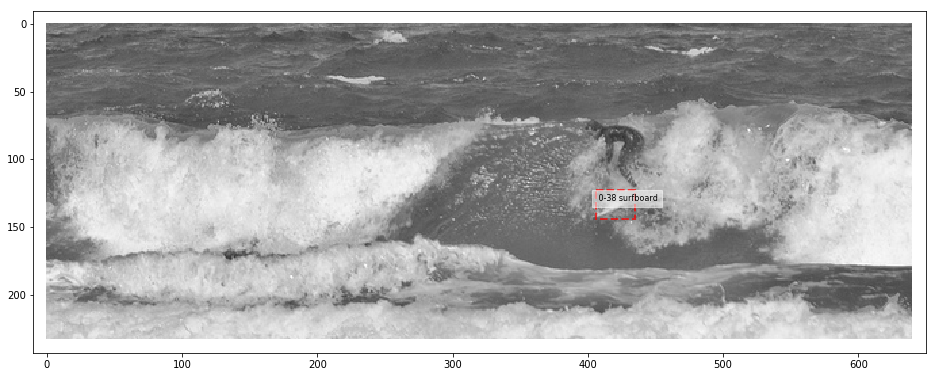

In [7]:
from mrcnn.datagen  import data_gen_simulate
# [75040, 89243]
### Image ids that cause failure in trainfcn mode. 
### 4598: 275557, 646: 1900, 26058:341061,25982: 471900, 18631:577876, 48015: 243914, 38621:124593, 21579:325236, 758:526514
### 28599: 481365, 30741:358189
IMAGE_IDS = [646]
# train_batch_x, train_batch_y = next(train_generator)
train_batch_x, train_batch_y = data_gen_simulate(dataset_train, mrcnn_model.config, IMAGE_IDS)
visualize.display_training_batch(dataset_train, train_batch_x)

### other image displays

####  Display Training / Validation Training set information

In [ ]:
print("Train Dataset Image Count: {}".format(len(dataset_train.image_ids)))
print("Training Dataset Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
    
print("Validation Dataset Image Count: {}".format(len(dataset_val.image_ids)))
print("Validation Dataset Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))    

#### Display top masks for a random group of images

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 7)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

#### Display a random image with instances and mask

In [ ]:
# Load random image and mask.
# image_id = np.random.choice(dataset_train.image_ids)


image    = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
print(class_ids.shape[0], bbox.shape[0])
# Display image and instances
visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)

## FCN `train_in_batches()`

#### setup datasets

 #### Display parameters

In [8]:
from mrcnn.utils        import log
# fcn_config.EPOCHS_TO_RUN  = 4
# fcn_config.LEARNING_RATE  = 0.1
fcn_model.config.VALIDATION_STEPS = 4
print('--- MRCNN-------------------------------------------------------')
log("Epochs to run       {} ".format(mrcnn_model.config.EPOCHS_TO_RUN))
log("Steps per epochs    {} ".format(mrcnn_model.config.STEPS_PER_EPOCH))
log("Batch size          {} ".format(mrcnn_model.config.BATCH_SIZE))
log("Learning Rate       {} ".format(mrcnn_model.config.LEARNING_RATE))
log("Momentum            {} ".format(mrcnn_model.config.LEARNING_MOMENTUM))
log("Weight Decay:       {} ".format(mrcnn_model.config.WEIGHT_DECAY       ))
log("VALIDATION_STEPS    {} ".format(mrcnn_model.config.VALIDATION_STEPS   ))
# log("Checkpoint Path:    {} ".format(mrcnn_model.checkpoint_path))
# log("REDUCE_LR_FACTOR    {} ".format(mrcnn_model.config.REDUCE_LR_FACTOR   ))
# log("REDUCE_LR_COOLDOWN  {} ".format(mrcnn_model.config.REDUCE_LR_COOLDOWN ))
# log("REDUCE_LR_PATIENCE  {} ".format(mrcnn_model.config.REDUCE_LR_PATIENCE ))
# log("MIN_LR              {} ".format(mrcnn_model.config.MIN_LR             ))
# log("EARLY_STOP_PATIENCE {} ".format(mrcnn_model.config.EARLY_STOP_PATIENCE))     

print('--- FCN --------------------------------------------------------')
log("Epochs to run       {} ".format(fcn_model.config.EPOCHS_TO_RUN))
log("Steps per epochs    {} ".format(fcn_model.config.STEPS_PER_EPOCH))
log("Batch size          {} ".format(fcn_model.config.BATCH_SIZE))
log("Learning Rate       {} ".format(fcn_model.config.LEARNING_RATE))
log("Momentum            {} ".format(fcn_model.config.LEARNING_MOMENTUM))
log("Weight Decay:       {} ".format(fcn_model.config.WEIGHT_DECAY       ))
log("VALIDATION_STEPS    {} ".format(fcn_model.config.VALIDATION_STEPS   ))
log("Checkpoint Path:    {} ".format(fcn_model.checkpoint_path))
log("REDUCE_LR_FACTOR    {} ".format(fcn_model.config.REDUCE_LR_FACTOR   ))
log("REDUCE_LR_COOLDOWN  {} ".format(fcn_model.config.REDUCE_LR_COOLDOWN ))
log("REDUCE_LR_PATIENCE  {} ".format(fcn_model.config.REDUCE_LR_PATIENCE ))
log("MIN_LR              {} ".format(fcn_model.config.MIN_LR             ))
log("EARLY_STOP_PATIENCE {} ".format(fcn_model.config.EARLY_STOP_PATIENCE))    

--- MRCNN-------------------------------------------------------
Epochs to run       2 
Steps per epochs    10 
Batch size          1 
Learning Rate       1e-05 
Momentum            0.9 
Weight Decay:       0.0001 
VALIDATION_STEPS    50 
--- FCN --------------------------------------------------------
Epochs to run       2 
Steps per epochs    10 
Batch size          1 
Learning Rate       1e-05 
Momentum            0.9 
Weight Decay:       0.0002 
VALIDATION_STEPS    4 
Checkpoint Path:    F:\models\train_fcn8_bce\fcn20181221T1548\fcn_{epoch:04d}.h5 
REDUCE_LR_FACTOR    0.5 
REDUCE_LR_COOLDOWN  15 
REDUCE_LR_PATIENCE  50 
MIN_LR              1e-10 
EARLY_STOP_PATIENCE 150 


#### Original Train_in_batches() call

In [ ]:
##----------------------------------------------------------------------------------------------
## Train the FCN only 
## Passing layers="heads" freezes all layers except the head
## layers. You can also pass a regular expression to select
## which layers to train by name pattern.
##----------------------------------------------------------------------------------------------            
# train_layers = ['all']
# loss_names   = ["fcn_MSE_loss"]
# fcn_config.LAST_EPOCH_RAN = 56
# fcn_model.epoch = fcn_config.LAST_EPOCH_RAN

# fcn_model.train_in_batches(
#             mrcnn_model,    
#             dataset_train,
#             dataset_val, 
#             layers = train_layers,
#             losses = loss_names
#             )


#### modified train_in_btches call - invokes compile2()

In [ ]:
##----------------------------------------------------------------------------------------------
## Train the FCN only 
## Passing layers="heads" freezes all layers except the head
## layers. You can also pass a regular expression to select
## which layers to train by name pattern.
##----------------------------------------------------------------------------------------------            
train_layers = ['all']
loss_names   = ["fcn_MSE_loss"]
fcn_config.LAST_EPOCH_RAN = 56
fcn_model.epoch = fcn_config.LAST_EPOCH_RAN

train_in_batches(fcn_model,
            mrcnn_model,    
            dataset_train,
            dataset_val, 
            layers = train_layers,
            losses = loss_names
            )


## Simulate Train in Batches - step by step

#### Prepare model (compile / callbacks)

In [9]:
# def train_in_batches(self,
#                 mrcnn_model,
#               train_dataset, 
#               val_dataset,  
#               layers            = None,
#               losses            = None,
train_layers      = ['all']
loss_names        = ["fcn_BCE_loss"]

fcn_model.epoch   = fcn_model.config.LAST_EPOCH_RAN = 0
self              = fcn_model
mrcnn_model       = mrcnn_model
train_dataset     = dataset_train
val_dataset       = dataset_val
layers            = train_layers
losses            = loss_names
learning_rate     = 0           
epochs            = 0
epochs_to_run     = 0 
batch_size        = 0 
steps_per_epoch   = 0
min_LR            = 0
debug             = False

'''
Train the model.
train_dataset, 
val_dataset:    Training and validation Dataset objects.

learning_rate:  The learning rate to train with

epochs:         Number of training epochs. Note that previous training epochs
                are considered to be done already, so this actually determines
                the epochs to train in total rather than in this particaular
                call.

layers:         Allows selecting wich layers to train. It can be:
                - A regular expression to match layer names to train
                - One of these predefined values:
                heads: The RPN, classifier and mask heads of the network
                all: All the layers
                3+: Train Resnet stage 3 and up
                4+: Train Resnet stage 4 and up
                5+: Train Resnet stage 5 and up
'''
assert self.mode == "training", "Create model in training mode."

if batch_size == 0 :
    batch_size = self.config.BATCH_SIZE

if epochs_to_run ==  0 :
    epochs_to_run = self.config.EPOCHS_TO_RUN

if steps_per_epoch == 0:
    steps_per_epoch = self.config.STEPS_PER_EPOCH

if min_LR == 0 :
    min_LR = self.config.MIN_LR

if learning_rate == 0:
    learning_rate = self.config.LEARNING_RATE

epochs = self.epoch + epochs_to_run

# use Pre-defined layer regular expressions
# if layers in self.layer_regex.keys():
    # layers = self.layer_regex[layers]
print(layers)
# train_regex_list = []
# for x in layers:
    # print( ' layers ias : ',x)
    # train_regex_list.append(x)
train_regex_list = [self.layer_regex[x] for x in layers]
print(train_regex_list)
layers = '|'.join(train_regex_list)        
print('layers regex :', layers)


##--------------------------------------------------------------------------------
## Data generators
##--------------------------------------------------------------------------------
# train_generator = data_generator(train_dataset, mrcnn_model.config, shuffle=True,
#                                  batch_size=batch_size)
# val_generator   = data_generator(val_dataset, mrcnn_model.config, shuffle=True,
#                                  batch_size=batch_size,
#                                  augment=False)

##--------------------------------------------------------------------------------
## Set trainable layers and compile
##--------------------------------------------------------------------------------
self.set_trainable(layers)            

##----------------------------------------------------------------------------------------------
## Setup optimizaion method 
##----------------------------------------------------------------------------------------------            
optimizer = self.set_optimizer()

# self.compile(learning_rate, self.config.LEARNING_MOMENTUM, losses)        
self.compile(losses, optimizer)

##--------------------------------------------------------------------------------
## get metrics from keras_model.metrics_names and setup callback metrics 
##--------------------------------------------------------------------------------
out_labels = self.get_deduped_metrics_names()
callback_metrics = out_labels + ['val_' + n for n in out_labels]

print()
print(' Post-compile out_labels from get_deduped_metrics_names() : ')
print(' ---------------------------------------------------------- ')
for i in out_labels:
    print('     -',i)
print()
print(' Post-compile Callback metrics monitored by progbar :')
print(' ----------------------------------------------------')
for i in callback_metrics:
    print('     -',i)

print()
print(' Post-compile Keras metric_names :') 
print(' ---------------------------------') 
for idx, i in enumerate(self.keras_model.metrics_names):
    print('     ',idx, '  ', i)

print()
print(' Post-compile Keras stateful_metric_names :') 
print(' ------------------------------------------') 
for idx, i in enumerate(self.keras_model.stateful_metric_names):
    print('     ',idx, '  ', i)

## Setup for stateful_metric_indices Validation process 
##--------------------------------------------------------------------------------
stateful_metric_indices = []
if hasattr(self, 'metrics'):
    for m in self.stateful_metric_functions:
        m.reset_states()
    stateful_metric_indices = [
        i for i, name in enumerate(self.metrics_names)
        if str(name) in self.stateful_metric_names]
else:
    stateful_metric_indices = []

##--------------------------------------------------------------------------------
## Callbacks
##--------------------------------------------------------------------------------
# call back for model checkpoint was originally (?) loss. chanegd to val_loss (which is default) 2-5-18
# copied from \keras\engine\training.py
# def _get_deduped_metrics_names(self):


callbacks_list = [
      keras.callbacks.ProgbarLogger(count_mode='steps',
                                    stateful_metrics=self.keras_model.stateful_metric_names)

    , keras.callbacks.BaseLogger(stateful_metrics=self.keras_model.stateful_metric_names)

    , keras.callbacks.TensorBoard(log_dir=self.log_dir,
                                  histogram_freq=1,
                                  write_graph=True,
                                  write_images=False, 
                                  write_grads=True,
                                  batch_size=self.config.BATCH_SIZE)
                                  # write_graph=True,

                                  # write_images=True,
                                  # embeddings_freq=0,
                                  # embeddings_layer_names=None,
                                  # embeddings_metadata=None)

    , keras.callbacks.ModelCheckpoint(self.checkpoint_path, 
                                      mode    = 'auto', 
                                      period  = self.config.CHECKPOINT_PERIOD, 
                                      monitor = 'val_loss', 
                                      verbose = 1, 
                                      save_best_only = True, 
                                      save_weights_only=True)

    , keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                        mode     = 'auto', 
                                        factor   = self.config.REDUCE_LR_FACTOR,   
                                        cooldown = self.config.REDUCE_LR_COOLDOWN,
                                        patience = self.config.REDUCE_LR_PATIENCE,
                                        min_delta= self.config.REDUCE_LR_MIN_DELTA,
                                        min_lr   = self.config.MIN_LR, 
                                        verbose  = 1)                                            

    , keras.callbacks.EarlyStopping(monitor='val_loss', 
                                        mode      = 'auto', 
                                        min_delta = self.config.EARLY_STOP_MIN_DELTA, 

                                        patience  = self.config.EARLY_STOP_PATIENCE, 
                                        verbose   = 1)                                            
    , keras.callbacks.History() 
]


callbacks =  keras.callbacks.CallbackList(callbacks = callbacks_list)
callbacks.set_model(self.keras_model)
callbacks.set_params({
    'batch_size': batch_size,
    'epochs': epochs,
    'steps': steps_per_epoch,
    'verbose': 1 ,
    'do_validation': True,
    'metrics': callback_metrics
})

    # 'samples': num_train_samples,
    # 'verbose': verbose,
    # 'do_validation': do_validation,
    # 'metrics': callback_metrics or [],

log(" ")
log("Training Start Parameters:")
log("--------------------------")
log("Starting at epoch     {} of {} epochs.".format(self.epoch, epochs))
log("Steps per epochs      {} ".format(steps_per_epoch))
log("Last epoch completed  {} ".format(self.epoch))
log("Batch size            {} ".format(batch_size))
log("Learning Rate         {} ".format(self.config.LEARNING_RATE))
log("Momentum              {} ".format(self.config.LEARNING_MOMENTUM))
log("Weight Decay:         {} ".format(self.config.WEIGHT_DECAY       ))
log("VALIDATION_STEPS      {} ".format(self.config.VALIDATION_STEPS   ))
log("REDUCE_LR_FACTOR      {} ".format(self.config.REDUCE_LR_FACTOR   ))
log("REDUCE_LR_COOLDOWN    {} ".format(self.config.REDUCE_LR_COOLDOWN ))
log("REDUCE_LR_PATIENCE    {} ".format(self.config.REDUCE_LR_PATIENCE ))
log("MIN_LR                {} ".format(self.config.MIN_LR             ))
log("EARLY_STOP_PATIENCE   {} ".format(self.config.EARLY_STOP_PATIENCE))        
log("Checkpoint Path:      {} ".format(self.checkpoint_path))


##----------------------------------------------------------------------------------------------
## If in debug mode write stdout intercepted IO to output file  
##----------------------------------------------------------------------------------------------            
if self.config.SYSOUT == 'FILE':
    utils.write_sysout(self.log_dir)

##--------------------------------------------------------------------------------
## Start main training loop
##--------------------------------------------------------------------------------
early_stopping  = False
val_steps = self.config.VALIDATION_STEPS
epoch_idx = self.epoch

['all']
['.*']
layers regex : .*

Selecting layers to train
-------------------------
Layer    Layer Name               Layer Type
   0  input_pr_hm_norm       (InputLayer          )   ............................no weights to train ]
   1  block1_conv1           (Conv2D              )   TRAIN 
   2  block1_conv2           (Conv2D              )   TRAIN 
   3  block1_pool            (MaxPooling2D        )   ............................no weights to train ]
   4  block2_conv1           (Conv2D              )   TRAIN 
   5  block2_conv2           (Conv2D              )   TRAIN 
   6  block2_pool            (MaxPooling2D        )   ............................no weights to train ]
   7  block3_conv1           (Conv2D              )   TRAIN 
   8  block3_conv2           (Conv2D              )   TRAIN 
   9  block3_conv3           (Conv2D              )   TRAIN 
  10  block3_pool            (MaxPooling2D        )   ............................no weights to train ]
  11  block4_conv1        

In [10]:
callbacks.on_train_begin()

In [ ]:
if epoch_idx >= epochs:
    print('Final epoch {} has already completed - Training will not proceed'.format(epochs))
else:

    while epoch_idx < epochs :

#### Start of epoch

In [11]:
callbacks.on_epoch_begin(epoch_idx)
epoch_logs = {}

Epoch 1/2


In [ ]:
        ##------------------------------------------------------------------------
        ## TRAINING Phase - emulating fit_generator()
        ##------------------------------------------------------------------------
#         for steps_index in range(steps_per_epoch):

In [12]:
steps_index = 0

#### Run one batch 

In [14]:
# print(' self.epoch {}   epochs {}  step {} '.format(self.epoch, epochs, steps_index))
batch_logs = {}
batch_logs['batch'] = steps_index
batch_logs['size']  = batch_size    

callbacks.on_batch_begin(steps_index, batch_logs)

# train_batch_x, train_batch_y = next(train_generator)


# print('len of train batch x' ,len(train_batch_x))
# for idx, i in  enumerate(train_batch_x):
    # print(idx, 'type: ', type(i), 'shape: ', i.shape)
# print('len of train batch y' ,len(train_batch_y))
# for idx, i in  enumerate(train_batch_y):
    # print(idx, 'type: ', type(i), 'shape: ', i.shape)
# print(type(output_rois))
# for i in model_output:
    # print( i.shape)       

## Run prediction on MRCNN  
try:
    results = mrcnn_model.keras_model.predict(train_batch_x)
    fcn_x = [train_batch_x[1]]
    fcn_x.extend(results[:4])

except Exception as e :
    print('failure on mrcnn predict - epoch {} , image ids: {} '.format(epoch_idx, train_batch_x[1][:,0]))
    print('Exception information:')
    print(str(e))

# print('size of results : ', len(results))
# for idx, i in  enumerate(x):
    # print(idx, 'type: ', type(i), 'shape: ', i.shape)

failure on mrcnn predict - epoch 0 , image ids: [646] 
Exception information:
Reshape cannot infer the missing input size for an empty tensor unless all specified input sizes are non-zero
	 [[Node: cntxt_layer/MultivariateNormalDiag_3/prob/affine_linear_operator/inverse/DistributionShape/make_batch_of_event_sample_matrices/Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](cntxt_layer/MultivariateNormalDiag_3/prob/affine_linear_operator/inverse/sub, cntxt_layer/MultivariateNormalDiag_3/prob/affine_linear_operator/inverse/DistributionShape/make_batch_of_event_sample_matrices/concat)]]


In [ ]:
## Train on FCN
try:
    outs = self.keras_model.train_on_batch(fcn_x , train_batch_y)                                            
except Exception as e :
    print('failure on fcn train - epoch {} , image ids: {} '.format(epoch_idx, train_batch_x[1][:,0]))
    print('Exception information:')
    print(str(e))                

# print('size of outputs from train_on_batch : ', len(outs), outs)
# for idx, i in  enumerate(outs):
    # print(idx, 'type: ', type(i), 'shape: ', i.shape)

if not isinstance(outs, list):
    outs = [outs]

for l, o in zip(out_labels, outs):
    print(' out label: ', l, ' out value: ', o,' shape: ', o.shape)
    batch_logs[l] = o

callbacks.on_batch_end(steps_index, batch_logs)
epoch_idx +=1

####  Validation phase

In [ ]:
##------------------------------------------------------------------------
## VALIDATION Phase - emulating evaluate_generator()
##------------------------------------------------------------------------
# print(' Start validation ')
# print(' ---------------- ')
# print(' Stateful metric indices:' )
# pp.pprint(stateful_metric_indices)


val_steps_done      = 0
val_outs_per_batch  = []
val_batch_sizes     = []

# setup validation progress bar if we wish
# progbar = Progbar(target=val_steps)

while val_steps_done < val_steps:
    # print(' ** Validation step: ', val_steps_done)

    mrcnn_val_x, mrcnn_val_y = next(val_generator)

    # print('len of train batch x' ,len(val_x))
    # for idx, i in  enumerate(val_x):
        # print(idx, 'type: ', type(i), 'shape: ', i.shape)

    ## Run prediction on MRCNN  
    try:
        val_results = mrcnn_model.keras_model.predict(mrcnn_val_x)
        fcn_val_x = [mrcnn_val_x[1]]
        fcn_val_x.extend(val_results[:4])   ## image_meta, pr_hm, pr_hm_scores, gt_hm, gt_hm_scores
    except Exception as e :
        print('failure on mrcnn predict (validation)- epoch {} , image ids: {} '.format(epoch_idx, mrcnn_val_x[1][:,0]))
        print('Exception information:')
        print(str(e))                

    # print('    mrcnn_model.predict() size of results : ', len(val_results))
    # for idx, i in  enumerate(xval_results):
        # print('    ',idx, 'type: ', type(i), 'shape: ', i.shape)

    ## Train on FCN
    try:
        outs2 = self.keras_model.test_on_batch( fcn_val_x , mrcnn_val_y)
        # print('\n valstep {} outs2 len:{} '.format(val_steps_done, len(outs2)))
        val_outs_per_batch.append(outs2)
        print('fcn_model.test_on_batch() size of results : ', len(outs2))
        for idx, i in  enumerate(outs2):
            print(idx, 'type: ', type(i), 'shape: ', i.shape, 'val: ', i)
    except Exception as e :
        print('failure on fcn train (validation)- epoch {} , image ids: {} '.format(epoch_idx, mrcnn_val_x[1][:,0]))                    
        print('Exception information:')
        print(str(e))                



    if isinstance(fcn_val_x, list):
        batch_size = fcn_val_x[0].shape[0]
    elif isinstance(fcn_val_x, dict):
        batch_size = list(fcn_val_x.values())[0].shape[0]
    else:
        batch_size = fcn_val_x.shape[0]

    if batch_size == 0:
        raise ValueError('Received an empty batch. '
                         'Batches should at least contain one item.')
    # else:
        # print('batch size:', batch_size)

    val_steps_done += 1
    val_batch_sizes.append(batch_size)
    # print validation progress bar if we wish
    # progbar.update(val_steps_done)

## calculate val_averages after all validations steps complete, which is passed 
## back to fit_generator() as val_outs 

In [ ]:
print('    val_batch_sizes            :', type(val_batch_sizes),' len :', len(val_batch_sizes), val_batch_sizes)
print('    val_batch_sizes-shape      :', np.asarray(val_batch_sizes).shape)

print('    val_outs_per_batch:        :', type(val_outs_per_batch),' len :', len(val_outs_per_batch))
print('    val_outs_per_batch - shape :', np.asarray(val_outs_per_batch).shape)
for i,j in enumerate(val_outs_per_batch):
    print('        batch: ', i, '  ', j)

val_averages = []
for i in range(len(outs2)):
    if i not in stateful_metric_indices:
        tt = [out[i] for out in val_outs_per_batch]
        # print(' tt type: ',type(tt), tt)
        # print('val_batch_sizes.shape' , type(val_batch_sizes), len(val_batch_sizes))
        val_averages.append(
                np.average([out[i] for out in val_outs_per_batch], axis = 0, weights=val_batch_sizes)
                           )
    else:
        val_averages.append(float(val_outs_per_batch[-1][i]))
if len(val_averages) == 1:
    val_averages = val_averages[0]
print()
print('val_averages :', val_averages)
print()

####  attempt to add histogram info to tensoflow summary 

In [ ]:
#-- (unsuccessful) attempt to add histogram info to tensoflow summary  ------------------------
print(' Tensordlow histogram attempt')
print('-----------------------------')
print('model targets:', self.keras_model.targets)
print(' Total loss  :', self.keras_model.total_loss)
print(' Metric Tensors:', self.keras_model.metrics_tensors)
fcn_val_y = self.keras_model.targets
fcn_val_sample_weights = self.keras_model.sample_weights


print(' len(fcn_val_x)  : ',len(fcn_val_x))
print(' len(fcn_val_y)  : ',len(fcn_val_y))
print(' len(mrcnn_val_y): ',len(mrcnn_val_y))

# fcn_val_x, fcn_val_y, fcn_val_sample_weights = my_standardize_user_data(self.keras_model, fcn_val_x, fcn_val_y, val_sample_weight)
fcn_val_data = fcn_val_x + fcn_val_y  + fcn_val_sample_weights

print(' len(fcn_val_x)             : ',len(fcn_val_x))
print(' len(fcn_val_y)             : ',len(fcn_val_y))
print(' len(fcn_val_sample_weights): ',len(fcn_val_sample_weights))
print(' len(fcn_val_data)          : ',len(fcn_val_data))
if self.keras_model.uses_learning_phase and not isinstance(KB.learning_phase(), int):
    print(' add ')
    fcn_val_data += [0.]
for cbk in callbacks:
    cbk.validation_data = fcn_val_data

#-------------------------------------------------------------------------------

####  end of epoch (training and validation) operations 

In [ ]:
#### ------------------------------------------------------------------------
## END OF EPOCH Phase 
##------------------------------------------------------------------------
## end of evaluate_generator() emulation
## val_averages returned back to fit_generator() as val_outs
## calculate val_outs after all validations steps complete
##------------------------------------------------------------------------
if not isinstance(val_averages, list):
    val_averages = [val_averages]
# Same labels assumed.
for l, o in zip(out_labels, val_averages):
    epoch_logs['val_' + l] = o

#----commented 31-10-18 replaced with above lines -------------------------------------------
# if not isinstance(outs2, list):
    # val_outs =  np.average(np.asarray(val_all_outs), weights=val_batch_sizes)
# else:
    # averages = []
    # for i in range(len(outs2)):
        # averages.append(np.average([out[i] for out in val_all_outs], axis = 0, weights=val_batch_sizes))
    # val_outs = averages
# if not isinstance(val_outs, list):
    # val_outs = [val_outs]

# # Same labels assumed.
# for l, o in zip(out_labels, val_outs):
    # # print(' Validations : out label: val_', l, ' out value: ', o)
    # epoch_logs['val_' + l] = o
#-------------------------------------------------------------------------------------

# write_log(callback, val_names, logs, batch_no//10)
# print('\n    validation logs output: ', val_outs)


epoch_logs.update({'lr': KB.eval(self.keras_model.optimizer.lr)})    
callbacks.on_epoch_end(epoch_idx, epoch_logs)
epoch_idx += 1
                

#### Check for early stop training conditions

In [ ]:
                for callback in callbacks:
                    # print(callback)
                    # pp.pprint(dir(callback.model))
                    if hasattr(callback.model, 'stop_training') and (callback.model.stop_training ==True):
                        print(' +++++++++++ ON EPOCH END CALLBACKS TRIGGERED STOP_TRAINING +++++++++++++')
                        print(callback.model, ' triggered stop_training +++++++++++++')
                        early_stopping = True
                        
                if early_stopping:
                    print('{}  Early Stopping triggered on epoch {} of {} epochs'.format(callback, epoch_idx, epochs))
                    break    
                
            ##-------------------------------
            ## end of training operations
            ##--------------------------------
            # if epoch_idx != self.epoch:
            # chkpoint.on_epoch_end(epoch_idx -1, batch_logs)
            callbacks.on_train_end()
            self.epoch = max(epoch_idx - 1, epochs)
            print('Final : self.epoch {}   epochs {}'.format(self.epoch, epochs))
            
        ##--------------------------------------------------------------------------------
        ## End main training loop
        ##--------------------------------------------------------------------------------
        return 
        

#### get_gradients()

In [ ]:
# pp.pprint(val_averages)
# print(out_labels)
# epoch_logs = {}
# print(epoch_logs)
print(self.keras_model.inputs)
print(self.keras_model.targets)
print(self.keras_model.sample_weights)
print(self.keras_model.uses_learning_phase)

In [ ]:
def get_gradients_from_model(model):
    """Return the gradient of every trainable weight in model

    Parameters
    -----------
    model : a keras model instance

    First, find all tensors which are trainable in the model. Surprisingly,
    `model.trainable_weights` will return tensors for which
    trainable=False has been set on their layer (last time I checked), hence the extra check.
    Next, get the gradients of the loss with respect to the weights.

    """
    weight_names = []
    weights = []
    for tensor in model.trainable_weights:
        ly = tensor.name.split('/')[0]
        print('Layer: ', ly, ' Tensor:', tensor.name , ' Trainable:', model.get_layer(ly).trainable)
        if model.get_layer(ly).trainable:
            weights.append(tensor)
            weight_names.append(tensor.name)
#     weights = [tensor for tensor in model.trainable_weights if model.get_layer(tensor.name[:-2]).trainable]
    optimizer = model.optimizer
    pp.pprint(optimizer.__dict__)
    return weight_names, optimizer.get_gradients(model.total_loss, weights)

def get_weights_from_model(model):
    """Return every trainable weight in model

    Parameters
    -----------
    model : a keras model instance

    First, find all tensors which are trainable in the model. Surprisingly,
    `model.trainable_weights` will return tensors for which
    trainable=False has been set on their layer (last time I checked), hence the extra check.
    

    """
    weight_names = []
    weights = []
    for tensor in model.trainable_weights:
        ly = tensor.name.split('/')[0]
        print('Layer: ', ly, ' Tensor:', tensor.name , ' Trainable:', model.get_layer(ly).trainable)
        if model.get_layer(ly).trainable:
            weights.append(tensor)
            weight_names.append(tensor.name)
#     weights = [tensor for tensor in model.trainable_weights if model.get_layer(tensor.name[:-2]).trainable]
    return weight_names, weights

In [ ]:
import keras.backend as KB

weight_names, gradients = get_gradients_from_model(fcn_model.keras_model)
weight_names2, weights = get_weights_from_model(fcn_model.keras_model)

In [ ]:
get_gradients = KB.function(fcn_model.keras_model.inputs, outputs=gradients)

get_weights = KB.function([], outputs=weights)

In [ ]:
print(len(weights), len(weight_names2))
for i, j in  zip(weight_names2, weights):
    print('name:', i, '      weights:',j)
    
print(len(gradients), len(weight_names))
for i, j in  zip(weight_names, gradients):
    print('name:', i, '      gradient:',j)

In [ ]:
np_gradients = get_gradients(fcn_x)

In [ ]:
for i, j in zip(weight_names, np_gradients):
    print('{:25s}  {:25s} \t\t {:10.7f} {:10.7f} {:+11.9f}' .format(i, str(j.shape), j.min(), j.max(), j.mean()))

In [ ]:
np_weights = get_weights([])

In [ ]:
print('{:25s}  {:25s} \t\t {:12s} {:10s} {:11s}' .format('name', 'shape', 'min()', 'max()', 'mean()'))
for i, j in zip(weight_names2, np_weights):
    print('{:25s}  {:25s} \t\t {:10.7f} {:10.7f} {:+11.9f}' .format(i, str(j.shape), j.min(), j.max(), j.mean()))

## Run data through MRCNN and FCN models

####  Display model input / output information

In [ ]:
mrcnn_model.layer_info()
print('\n FCN')
fcn_model.layer_info()

In [ ]:
# model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)
# model_output = get_layer_output_1(mrcnn_model.keras_model, train_batch_x, [4,5,6,7,9,10,11,12,13,14], 1)
# model_output = get_layer_output_1(mrcnn_model.keras_model, train_batch_x, [0,1,2,3,4,5,6,7,9,10,11], 1)
model_output = get_layer_output_1(mrcnn_model.keras_model, train_batch_x, [0,1,2,3,4,5], 1)


### Load input and output tensors

In [ ]:
print(len(model_output))

# output_rois               = model_output[0]          # layer:  4   shape: (1, 200, 4)
# target_class_ids          = model_output[1]          # layer:  5   shape: (1, 200)
# target_bbox_deltas        = model_output[2]          # layer:  6   shape: (1, 200, 4)
# roi_gt_boxes              = model_output[3]          # layer:  7   shape: (1, 200, 4)
# mrcnn_class               = model_output[4]          # layer:  8   shape: (1, 200, 81)
# mrcnn_bbox                = model_output[5]          # layer:  9   shape: (1, 200, 81, 4)
# pred_refined_tensor       = model_output[6]          # layer: 16   shape: (1, 81, 25, 7)
# output_rois               = model_output[0]          # layer:  0   shape: (2, 200, 4)
# target_class_ids          = model_output[1]          # layer:  1   shape: (2, 200)
# target_bbox_deltas        = model_output[2]          # layer:  2   shape: (2, 200, 4)
# roi_gt_boxes              = model_output[3]          # layer:  3   shape: (2, 200, 4)
# mrcnn_class               = model_output[4]          # layer:  4   shape: (2, 200, 81)
# mrcnn_bbox                = model_output[5]          # layer:  5   shape: (2, 200, 81, 4)
# model_pred_heatmap_norm         = model_output[6]          # layer:  6   shape: (2, 256, 256, 81)
# model_pred_heatmap_scores       = model_output[7]          # layer:  7   shape: (2, 81, 25, 11)
# model_gt_heatmap_scores         = model_output[8]          # layer:  9   shape: (2, 81, 25, 11)
# model_pred_tensor               = model_output[9]          # layer: 10   shape: (2, 81, 25, 8)
# model_gt_tensor                 = model_output[10]          # layer: 11   shape: (2, 81, 25, 8)

pred_heatmap_norm         = model_output[0]          # layer:  0   shape: (2, 256, 256, 81)
pred_heatmap_scores       = model_output[1]          # layer:  1   shape: (2, 81, 200, 11)
gt_heatmap_norm           = model_output[2]          # layer:  2   shape: (2, 256, 256, 81)
gt_heatmap_scores         = model_output[3]          # layer:  3   shape: (2, 81, 200, 11)
pred_tensor               = model_output[4]          # layer:  4   shape: (2, 81, 200, 8)
gt_tensor                 = model_output[5]          # layer:  5   shape: (2, 81, 200, 8)
for i in model_output:
    print( i.shape)

In [ ]:
# fcn_input = [pred_heatmap_norm, pred_heatmap_scores, gt_heatmap_norm, gt_heatmap_scores] 
model_output2 = get_layer_output_1(fcn_model.keras_model, fcn_input, [0,1], 1)

### Load input data

In [ ]:
input_image          =  train_batch_x[0]
input_image_meta     =  train_batch_x[1]
# input_rpn_match      =  train_batch_x[2]
# input_rpn_bbox       =  train_batch_x[3]
input_gt_class_ids   =  train_batch_x[4]
input_gt_bboxes      =  train_batch_x[5]
print(' Input image shape is    :', input_image.shape)
print(' input_image_meta        :', input_image_meta[0,:10])
# print(' input_rpn_match         :', input_rpn_match.shape)
# print(' input_rpn_bbox          :', input_rpn_bbox.shape)
print(' input_gt_class_ids      :', input_gt_class_ids.shape)
print(' input_gt_bboxes         :', input_gt_bboxes.shape)
# h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
# input_gt_bboxes_norm = tf.identity(input_gt_bboxes / [h,w,h,w])
# print(' input_gt_bboxes_norm    :', input_gt_bboxes_norm.shape)

## Display output from model

####  `input_gt_class_ids`, `input_gt_bboxes`

In [ ]:
# print(roi_gt_boxes[0,:50] * [1024,1024,1024,1024])
print(input_gt_class_ids[0])
print(input_gt_bboxes[0,:10])
# for i in range(input_gt_class_ids.shape[1]):
#     if input_gt_class_ids[0,i] == 1:
#         print(input_gt_class_ids[0,i], '   ', input_gt_bboxes[0,i])

####  Display `output_rois`

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img = 0
print(' output_rois')
print(output_rois.shape)
# print(output_rois[0,:40,:])
print(output_rois [0,:40,:]* [1024, 1024, 1024, 1024])

####  `max_mrcnn_class` , `argmax_mrcnn_class`

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
print(' mrcnn_class', mrcnn_class.shape)
# print( mrcnn_class[0,0,:])
# 
max_mrcnn_class    = np.max(mrcnn_class, axis = (0,2))
argmax_mrcnn_class = np.argmax(mrcnn_class, axis = 2)

# print()
print('\n mrcnn_class Max Values   : ', max_mrcnn_class.shape)
print(max_mrcnn_class)

# print()
print(' mrcnn_class Argmax Values: ', argmax_mrcnn_class.shape)
print(argmax_mrcnn_class[0])

print(' target_class_ds    Values: ', target_class_ids.shape)
print(target_class_ids[0])

# for i in range(100):
#     print('Predicted: ', argmax_mrcnn_class[0,i],  '  Actual ', target_class_ids[0,i])
 

#### Display  `target_class_ids()`

In [ ]:
print(' target_class_ids')
print(target_class_ids.shape)
print(target_class_ids[0,:70])

####  apply `deltas` from predicted delta `mrcnn_bbox`  to  `output_rois` to obtain refined rois 

In [ ]:
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img_idx = 0 

print('output_rois',output_rois.shape, 'deltas ', deltas.shape)
cls = 1
for i in range(input_gt_class_ids.shape[1]):
    if input_gt_class_ids[0,i] == cls:
        print(input_gt_class_ids[0,i], '   ', input_gt_bboxes[0,i])

        
print()        
for i in range(output_rois.shape[1]):
    if classes[0,i] ==cls:
        print(' i ', i, 'class: ',classes[0,i])
#         print('   orig           : ', output_rois[0,i])
        d1 = deltas[0,i] * mrcnn_config.BBOX_STD_DEV
#         print('   delta          : ', deltas[0,i],'   delta * std dev: ', d1)
        d2 = utils.apply_box_delta(output_rois[0,i],d1)
#         print('   refined        : ', d2)
#         print()
        print('   orig           : ',output_rois[0,i] * [1024,1024,1024,1024])
        print('   refined        : ', d2 * [1024,1024,1024,1024]) 
        print('   roi_gt_bboxes  : ', roi_gt_boxes[0,i]* [1024,1024,1024,1024]) 
        print()
        print('   pred delta     : ', deltas[0,i] )
        print('   tgt delta      : ', target_bbox_deltas[0,i] )
        
        print()


####  Display roi_gt_boxes , and class_ids vs. output_bbox and prediceted class_ids

In [ ]:
print(ref_out_roi)

In [ ]:
ref_out_roi1 = ref_out_roi * [1024,1024,1024,1024]
print(ref_out_roi1)
window = np.array([0,0,1024,1024], dtype =float)
print(window.shape)
ref_out_roi2  = utils.clip_to_window_np( window, ref_out_roi1)
print(ref_out_roi2.shape)
for i in range(200):
    print(ref_out_roi1[i],' --- ', ref_out_roi2[i])

#### Display pred_refined_tensor and gt_tensor

In [ ]:
for cls in [1]:
    for box in range(20):
        print(pred_tensor[0,cls,box])
        print(gt_tensor[0,cls,box])
        print()

####  Display roi_gt_boxes along with corresponding refined/clipped output_rois

In [ ]:
img_id = 0
print(roi_gt_boxes[0].shape, target_class_ids[0].shape , np.expand_dims(target_class_ids[0],axis=-1).shape)
classes, deltas = utils.get_predicted_mrcnn_deltas(mrcnn_class, mrcnn_bbox, verbose=True)
deltas *= mrcnn_config.BBOX_STD_DEV
print('classes.shape: ',classes.shape, ' deltas.shape: ',deltas.shape)

ref_out_roi = utils.apply_box_deltas_np(output_rois[img_id],deltas[img_id])
#     ##   Clip boxes to image window    
# print(ref_out_roi.shape)
window = np.array([0,0,1024,1024], dtype =float)
clipped_out_roi  = utils.clip_to_window_np( window, ref_out_roi*[1024,1024,1024,1024])

for i in range(200):
#     ref_out_roi = utils.apply_box_delta_np(output_rois[0],d1[0])
#     if classes[img_id,i] == 1 or target_class_ids[img_id,i] == 1 :

    print('idx: ',200-i,' GT Cls: ', target_class_ids[img_id,i]  , ' -', roi_gt_boxes[img_id,i]*[1024,1024,1024,1024], 
                    ' PR Cls: ', classes[img_id,i],' - ', ref_out_roi[i]*[1024.0,1024.0,1024.0,1024.0] ,
                     'ClpdCls: ', clipped_out_roi[i]   ) #) *[1024,1024,1024,1024]

#### display gt_heatmap_scores and pred_heatmap_scores outputs

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=200, suppress=True)
# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])
img_id = 1
print(' GT Heatmap Scores')

print('gt_heatmap_scores: ', gt_heatmap_scores.dtype,  gt_heatmap_scores.shape)
print('pred_heatmap_scores: ', pred_heatmap_scores.dtype,  pred_heatmap_scores.shape)

# print(gt_heatmap_scores[img,1])
# for img_id in range(mrcnn_config.BATCH_SIZE):

for img_id in [0]:    # print(pred_refined_heatmap_scores[img_id,:4])
    pr_class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    gt_class_ids = np.unique(gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist() 
    union_class_ids = np.union1d(pr_class_ids, gt_class_ids)
    print('-'*56)
    print('Image : {}  GT ClassIds: {}   PR ClassIds: {} '.format(img_id, gt_class_ids, pr_class_ids))
    print('Image : {}  Union ClassIds: {}'.format(img_id, union_class_ids))
    print('-'*56)
    for cls in union_class_ids:  
        print()
        for i in range(25):
#             print(' GT: img_id:',img_id, ' cls: ',cls, ' -',gt_tensor[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
#             print(' PR: img_id:',img_id, ' cls: ',cls, ' -',pred_tensor[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])

            print(' GT: img/cls:',img_id, '/',cls, ' -',gt_heatmap_scores[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
            print(' PR: img/cls:',img_id, '/',cls, ' -',pred_heatmap_scores[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])
            print()

####  Display `Pred_Tensor`, `Pred_heatmap`, `mrcnn_class`

In [ ]:
# np.set_printoptions(precision=4, threshold=None, linewidth=150, suppress=True)
np.set_printoptions(precision=4, threshold=4000, linewidth=210, suppress=True)
img = 0

# max_score = np.max(mrcnn_class, axis = -1)
# max_class = np.argmax(mrcnn_class, axis = -1)
# # print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
# print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
# print('max class[',img,']\n',max_class[img])
# print('max score[',img,']\n',max_score[img])
# print('mrcnn class.shape ',mrcnn_class.shape)
# print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])

print('input_gt_class_ids')
print(input_gt_class_ids[0])

# print(' rpn_bbox')
# print(rpn_bbox.shape)
# print(rpn_bbox[0,:100,:])

# print(' rpn_roi_proposals')
# print(rpn_roi_proposals.shape)
# print(rpn_roi_proposals[0,:100,:])

print(' output_rois')
print(output_rois.shape)
# print(output_rois[0,:40,:])
print(output_rois [0,:40,:]* [1024, 1024, 1024, 1024])

print(' target_class_ids')
print(target_class_ids.shape)
print(target_class_ids[0,:40])
# print(output_rois [0,:40,:]* [1024, 1024, 1024, 1024])

# print(' Pred_tensor')
# print(pred_tensor.shape)
# print(pred_tensor[img,:,:10])

# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])

# print(' mrcnn_class')
# print( mrcnn_class.shape)
# print( mrcnn_class[0,:,:])

# print(' mrcnn_bbox')
# print( mrcnn_bbox.shape)
# print( mrcnn_bbox)

# print(' roi_gt_boxes')
# print(roi_gt_boxes.shape)
# print(roi_gt_boxes[img,:,:])

# print(' Pred Heatmap Scores')
# print(pred_heatmap_scores.dtype, pred_heatmap_scores.shape)
# print(pred_heatmap_scores[img,1])

# print(' FCN Scores')
# print(fcn_scores.dtype)
# for cls in range(4):
#     print(pred_heatmap_scores[img,cls,:10])
#     print(fcn_scores[img,cls,:10,2:])

  

####  Display `output_rois` for visual check - passed on to  `build_pred_tensor()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('output_rois shape is ', output_rois.shape)
img = 0
for img in [0]:
    print('Image ', img , ' ------------')
    print(output_rois[img])

####  Display  - `pred_refined_tensor` which is passed on to  `build_heatmap()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
img_id = 0
# print('scatter shape is ', pred_scatt.get_shape())
print('model_pred_tensor shape is ', model_pred_tensor.shape)
print(input_image_meta[0,:10])
pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
print('Image : {}  PR ClassIds: {} '.format(img_id, pr_class_ids))
for k in pr_class_ids:
    print('Image ', img , '/ Class ',k,' ------------')
    print(model_pred_tensor[img,k,:30])
    

####  Compare  `pred_heatmap_scores` vs. `pred_refined_heatmap_scores`

###  Setup tensors to be passed to `build_predictions ()`    

In [ ]:
mrcnn_bbox  = tf.identity(mrcnn_bbox)
mrcnn_class = tf.identity(mrcnn_class)
norm_input_rois = tf.identity(output_rois)
config      = mrcnn_config
sess = KB.get_session()
print(' Keras session :', sess)
import mrcnn.utils as utils

###  Run TF graph

In [ ]:
# with sess1.as_default():
# FeedList = [positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_class_ids, roi_gt_boxes, roi_gt_box_assignment ]
# FeedList = [ rois, roi_gt_class_ids,  roi_gt_deltas, roi_gt_boxes]
Fetches  = [ pred_heatmap, pred_heatmap_norm, pred_heatmap_scores]
tt = sess.run(Fetches)
print(type(tt), len(tt))
for i in tt:
    print(type(i), i.shape)